# Assigment III : Bayesian Networks

In this exercise you will get acquainted with some concepts in from probability and graphical models, specifically Bayesian Networks. 

Recall from the lectures that  Bayesian Networks are composed of Conditional Probability Tables. We provide a basic implementation of such tables named under the class `Cpt`.

(You might see an error about dot_parser after executing this cell. This is nothing to worry about.)

In [127]:
from ai_algorithms.Bayes_exercise import Cpt
%autosave 0

Autosave disabled


Let's write a simple conditional probability table for the random variable *Rain* given *Cloudy*, representing $P(\text{Rain} \, | \, \text{Cloudy})$ . 

In [128]:
#Here we say that there is a 0.1 probability of raining if there are no clouds, and 0.8 if it is cloudy
rain = Cpt('Rain', [[0.9,0.1],
                    [0.2,0.8]], 
           ['Cloudy'])
print rain


		Rain
| Cloudy   |   False |   True |
|:---------|--------:|-------:|
| False    |     0.9 |    0.1 |
| True     |     0.2 |    0.8 |



Let's define some other Cpts:

In [129]:
# We decide that cloudy is not conditioned on any variable other variable, so we define a prior probability for it
cloudy = Cpt('Cloudy', [[0.6, 0.4]],[])
print cloudy


	Cloudy
|   False |   True |
|--------:|-------:|
|     0.6 |    0.4 |



In [130]:
# Note that WetGrass is conditioned on two variables
wetgrass = Cpt('WetGrass', [[0.8,0.2],
                            [0.4,0.6],
                            [0.3,0.7],
                            [0.1,0.9]], ['Rain', 'Sprinkler'])
print wetgrass


			WetGrass
| Rain   | Sprinkler   |   False |   True |
|:-------|:------------|--------:|-------:|
| False  | False       |     0.8 |    0.2 |
| False  | True        |     0.4 |    0.6 |
| True   | False       |     0.3 |    0.7 |
| True   | True        |     0.1 |    0.9 |



In [131]:
sprinkler = Cpt('Sprinkler', [[0.2,0.8],                          
                              [0.7,0.3]], ['Cloudy'])
print sprinkler


		Sprinkler
| Cloudy   |   False |   True |
|:---------|--------:|-------:|
| False    |     0.2 |    0.8 |
| True     |     0.7 |    0.3 |



Note that each row in the in the CPT needs to add up to 1. Otherwise, an error will be raised. 

You can get a row from the CPT by using the `conditioned` method, which accepts a dict with the state of the conditioned variables. 
You must specify **all conditioned variables**, else you will get an error.

In [132]:
conditioned_state = dict(Rain=True, Sprinkler=False)
wetgrass.conditioned(conditioned_state)

[0.3, 0.7]

Your first task will be to obtain samples from the CPT, given a specific state of the conditioned variables.
Again, you can obtain the probabilities of a specific row of the CPT using the `conditioned` method.

In [133]:
wetgrass.conditioned(dict(Rain=True, Sprinkler=True))

[0.1, 0.9]

# Exercise 1: Sampling a CPT [6 P.]

Given a Cpt and a configuration, implement a function to obtain samples from the univariate distribution $P(x\,|\,\text{conditioned_variables})$. The output is either of the boolean constants `True` or `False`, e.g:
```
sample_cpt(wetgrass, dict(Rain=True,Sprinkler=True))
```
could (for example) return 
```
True
```
The function takes a conditional probability table `cpt` for an arbitrary random variable. Let's call the random variable RV for the sake of explanation. The function also takes the evidence variables as its second argument `conditioned`. The function shall use the given `cpt` to calculate the probability of the two possible outcomes of RV (True or False) and then return an actual outcome according to the calculated probability.

Example: If the function calculates $P(RV=\mathrm{True}\, |\, \mathrm{evidence}) = 0.2$ then the function shall return `True` in 20% of the function calls (20% probability) and `False` in 80% of the function calls (80% probability).

Recall that in Python, you can generate random numbers by using the function `random` from the module `random`.

In [134]:
import random
random.random()

0.48176223061903445

In [135]:
def sample_cpt(cpt, conditioned):
    '''Returns a sample (True/False) from the CPT, given the conditioned variables'''
    f, t = cpt.conditioned(dict(Rain=True, Sprinkler=True))
    if random.random() < f:
        return False
    else:
        return True

In [136]:
# This function is here for convenience and grading, there is no need to modify it. 
def sample_cpt_multiple(cpt,conditioned,num_samples):
    '''Returns multiple samples from the the CPT'''
    return [sample_cpt(cpt, conditioned) for _ in range(num_samples)]


# Bayesian Network Class (For exercises 2 to 5)

Bayesian Networks are one of the most popular probabilistic graphical models. The are constructed using multiple CPTs. 

Here we also give an **incomplete implementation** of a Bayesian Network. Your task will be to implement some functions of this class. 

Dont worry if you do not understand everything that is happening, because you will not need most of it. The implementaion uses the `networkx` library to model the graph underlying the Bayesian Network. You can read its documentation [here](http://networkx.github.io/documentation/networkx-1.9.1/), but for these exercises you should be able to get along with the functions and method described in this notebook.

In [137]:
import itertools
import networkx as nx
from networkx import DiGraph
from tabulate import tabulate
from bitstring import BitArray
from IPython.display import Image, display_png

class BayesNet(DiGraph, nx.Graph):
    def __init__(self, cpts):
        DiGraph.__init__(self)
        self.cpts = cpts
        self.build_graph()

    def build_graph(self):
        for cpt in self.cpts:
            self.add_node(cpt.node, attr_dict=dict(cpt=cpt, texlbl=cpt.node))
            for parent in cpt.parents:
                self.add_edge(parent, cpt.node)

    def marginal_enumeration(self, query, conditioned):
        '''Returns the marginal probability P(query | conditioned) of 
        the query variable given the conditioned variables'''
        print "query: {}, conditioned: {}".format(query, conditioned)
        assert len(query.keys()) == 1, "Can only have one query variable"

        trueList = []
        diffState = list(set(self.node.keys()) - set(query) - set(conditioned))
        for i in itertools.product([True, False], repeat=len(diffState)):
            trueList.append(i)
        dictAssign = [{x:y for x, y in zip(diffState, i)} for i in trueList]

        pEventCond = 0
        for i in dictAssign:
            variables = dict(set(query.items()) ^ set(conditioned.items()) ^ set(i.items()))
            pEventCond += self.probability_configuration(variables)

        # calculate p(cond)
        trueList = []
        diffState = list(set(self.node.keys()) - set(conditioned))
        for i in itertools.product([True, False], repeat=len(diffState)):
            trueList.append(i)
        dictAssign = [{x:y for x, y in zip(diffState, i)} for i in trueList]
        pCond = 0
        for i in dictAssign:
            variables = dict(set(conditioned.items()) ^ set(i.items()))
            pCond += self.probability_configuration(variables)

        return pEventCond / pCond

    def probability_configuration(self,assignments):
        '''The probability of an assigment of all variables in 
        the Bayesian Network. '''   
        list = assignments.keys()

        p = 1

        for i in list:
            parents = []
            for j in list:
                if i == j:
                    continue
                if j in self.node[i]['cpt'].parents:
                    parents.append(j)
            
            condition = {i:assignments[i] for i in parents}

            if not assignments[i]:
                p *= self.node[i]['cpt'].conditioned(condition)[0]
            else:
                p *= self.node[i]['cpt'].conditioned(condition)[1]

        return p
    def forward_sample(self):
        '''Computes a sample from the prior distribution. 
        Returns a dictionary with the state (True/False) of 
        each variable'''
        state = self.node.keys()
        trueList = []
        for i in itertools.product([True, False], repeat=len(state)):
            trueList.append(i)

        dictList = [{x:y for x, y in zip(state, i)} for i in trueList]
        
        numRand = random.random()
        
        
        for i in dictList:
            prob = self.probability_configuration(i)
            if numRand < prob:
                return i
            numRand -= prob

    def __str__(self):
        return '<Bayes Net' + str(self.nodes())+'>'
        
    def __repr__(self):
        return self.__str__()

    def as_png(self):
        pd = nx.to_pydot(self)
        pd.write_png('/tmp/out.png')                
        return Image('/tmp/out.png')

To get used to it, lets make a simple Bayesian Network using the Cpts

In [138]:
bn = BayesNet([cloudy, rain, sprinkler, wetgrass])

You can visualize the structure using the following function

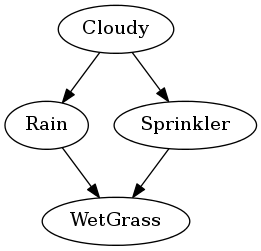

In [139]:
bn.as_png()

Some useful methods and accesors that you have available in the BayesNet class:

In [140]:
print('Getting all nodes')
print(bn.nodes())
print "=="
print('Accessing the CPT associated to a node')
print(bn.node['Rain']['cpt'])
print "=="
print('Children of a node')
print(bn.successors('Cloudy'))
print "=="
print('Parents of a node')
print(bn.predecessors('Rain'))

Getting all nodes
['WetGrass', 'Rain', 'Cloudy', 'Sprinkler']
==
Accessing the CPT associated to a node

		Rain
| Cloudy   |   False |   True |
|:---------|--------:|-------:|
| False    |     0.9 |    0.1 |
| True     |     0.2 |    0.8 |

==
Children of a node
['Sprinkler', 'Rain']
==
Parents of a node
['Cloudy']


Now we are ready to implement some methods of this class to give it more functionalities!

# Exercise 2 : Evaluating probabilities in a Bayesian Network [9 P.]



The most basic thing we can do in a Bayesian Network is to evaluate the probability of a given world state $P(x)$.
For this all you need to do is apply the definition of how a Bayesian Network defines probabilities. 



**Complete the probability_configuration method in the BayesNet class. **

The input variable `assignments` will be the a dict with the truth values of **all** variables in the network, e.g.

```
assignments = dict(Sprinkler=True,WetGrass=False,Rain=True,Cloudy=True)
bn.probability_configuration(assignments)
```

Recall that the name `self` inside a class refers to the object, which in this case will be the `BayesNet` instance.


# Exercise 3 : Computing a posterior probability (Exact Inference) [24 P.]

If you can compute the probability of a single assignment, you can now compute more advanced queries. 
Let's say that we split the variables in three groups: x,y,z. Now we are interested in computing queries of type $P(x \, | \, z)$. 
The variables in $x$ will be the query variables. The conditioned variables (fixed) are $z$. The $y$ variables do not appear in the expression, that means we need to *marginalize out* the $y$ variables.

** Complete the marginal_enumeration method in the BayesNet class. **

Again, the inputs (`query`, `conditioned`) are dictionaries specifying the truth value of each variable in the respective groups. 

In this exercise, you can assume that ** `query` will just contain one variable**
```
bn.marginal_enumeration(query=dict(Rain=True), conditioned=dict(WetGrass=False))
```

**Advice**: Remember from the lectures that you can compute unnormalized probabilities and normalize them afterwards using the complementary query.

## Question 1  [3 P.]: 
*( after you implemented marginal_enumeration)*

Let's make another simple Bayesian Network

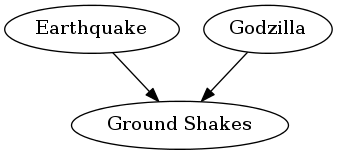

In [141]:
earthquake = Cpt('Earthquake',[[0.999,0.001]], [])
godzilla = Cpt('Godzilla', [[0.99,0.01]], [])
ground_shakes = Cpt('Ground Shakes', [[0.99,0.01], [0.7,0.3], [0.1,0.9], [0.01,0.99]], ['Godzilla','Earthquake'])
bn_gs = BayesNet([earthquake, godzilla, ground_shakes])
bn_gs.as_png()

And observe the following probabilities: 

In [142]:
print bn_gs.marginal_enumeration(query={'Earthquake':True},conditioned={'Ground Shakes':True})
print bn_gs.marginal_enumeration(query={'Earthquake':True},conditioned={'Godzilla':True,'Ground Shakes':True})

query: {'Earthquake': True}, conditioned: {'Ground Shakes': True}
0.0159943714822
query: {'Earthquake': True}, conditioned: {'Godzilla': True, 'Ground Shakes': True}
0.001099890011


What is this effect called:

In [143]:
def question_1():
    '''Uncomment one of the following'''
    #return 'conditioning'
    #return 'explaining away'
    return 'marginalization'
    #return 'sampling'
    pass

# Exercise 4: Sampling a Bayes Network with no evidence [10 P.]

If you can already sample from a CPT, it is not much more difficult to sample from the prior of a Bayesian Network. This is also called forward sampling. 

** Complete the forward_sample method in the BayesNet class. **

A sample will be specified as a dictionary with the state of each node, e.g.
```
bn.forward_sample()
```
returns
```
dict(Rain=True, WetGrass=False, Sprinkler=True, Cloudy=True)
```

You should use the functions to get parents and children of the nodes. You could also use the function `nx.topological_sort(self)` ([Documentation](http://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.dag.topological_sort.html)) to get a topological ordering of the nodes. 

### Plotting results

Optionally, you can visualize the results from samples using the following code

In [144]:
def compute_marginals(samples):
    ''' Computes marginal probabilities from samples'''
    from collections import Counter
    c = Counter()
    for sample in samples:
        c.update(sample)    
    nsamples = len(samples)    
    return  {k: float(v) / nsamples for k, v in c.iteritems()}

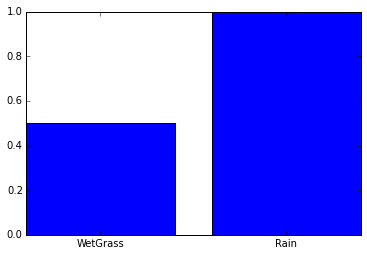

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
samples = [dict(Rain=True, WetGrass=False), dict(Rain=True, WetGrass=True)]  # put your samples here
D = compute_marginals(samples)
plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys());

# Exercise 5: Computing probabilities by sampling (Rejection Sampling) [15 P.]

Rejection sampling is perhaps the simplest algorithm to compute approximations for more advanced probabilistic queries. 
Just as in a previous exercise, the input to the `rejection_sampling` function is the state of the *query* variables and the *conditioned* variables in the form of a dictionary with their truth value each. The variables that are neither query nor conditioned are of no interest. 

Use rejection sampling to compute an approximation of the probability $P(query\, | \, conditioned)$.


** Implement the function rejection_sampling **

This is an example function call:
```
rejection_sampling(bn, dict(WetGrass=True, Rain=False), dict(Cloudy=True), 100)
```

The function should return a single number as the approximate probability. `num_samples` is the total number of samples that should be drawn to get the approximate probability.

In [146]:
def rejection_sampling(bn, query, conditioned, num_samples):    
    '''Computes an approximation to the probability for P(query | conditioned) '''
    if num_samples < 1:
        return 0

    c1 = 0
    c2 = 0

    for i in xrange(num_samples):
        sample = set(bn.forward_sample().items())

        if set(conditioned.items()) <= sample:
            c2 += 1
            if set(query.items()) <= sample:
                c1 += 1

    return c1 * 1.0 / c2

        